# Assignment 1

# Density estimation using Real NVP

Normalizing flows is the class of probabilistic models that provides flexible parametrical probabilistic models, where the probability density function can be computed exactly. In the assignment, we will consider a real-valued non-volume preserving normalizing flows (Real NVP) -- a special case of normalizing flow.

#### Problem setting

Our goal is to train a generative network $g_\theta:  Z \rightarrow X, g = f^{-1}$ that maps latent variable $z \sim p(z)$ to a sample $x \sim p(x)$. Where $p(z)$ is a prior distibiution and $p(x)$ is a data distibution. An illustrative example is provided below.

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/2d-example.png)

#### Change of variable formula

Given an observed data variable $x \in X$,
a simple prior probability distribution $p_{Z}$ on a latent variable $z \in Z$,
and a bijection $f: X \rightarrow Z$ (with $g = f^{-1}$),
the change of variable formula defines a model distribution of $X$ by
<!-- \begin{align}
p_{X}(x) &= p_{Z}\big(f(x)\big) \left|\det\left(\cfrac{\partial f(x)}{\partial x^T} \right)\right|
\label{eq:change-variables}\\
\log\left(p_{X}(x)\right) &= \log\Big(p_{Z}\big(f(x)\big)\Big) + \log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
,
\end{align} -->

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/f.png)
where $\frac{\partial f(x)}{\partial x^T}$ is the Jacobian of $f$ at $x$.

Exact samples from the resulting distribution can be generated by using the inverse transform sampling rule. A sample $z \sim p_{Z}$ is drawn in the latent space, and its inverse image $x = f^{-1}(z) = g(z)$ generates a sample in the original space. Computing the density at a point $x$ is accomplished by computing the density of its image $f(x)$ and multiplying by the associated Jacobian determinant $\det\left(\frac{\partial f(x)}{\partial x^T}\right)$.

#### Real NVP

Real NVP presents a class of functions where $\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)$ can be computed efficiently (see, 3.3 Properties, https://arxiv.org/abs/1605.08803). Every layer of Real NVP is a coupling layer followed by permutation layer. Combination of coupling and permutation layers can be implemented as a masked version of the coupling layer:
## $$y = b \odot x + (1 - b) \odot \Big(x \odot \exp\big(s(b \odot x)\big) + t(b \odot x)\Big)$$

where $s$ and $t$ stand for scale and translation, and are functions from $R^{D} \mapsto R^{D}$, and $\odot$ is the Hadamard product or element-wise product, $b$ is a binary mask. For more details on the model see the paper Density estimation using Real NVP https://arxiv.org/abs/1605.08803.

# In this assignment:
1. Implementation of Real NVP
2. Training Real NVP on moons dataset
3. Visualization of the generative model
4. Optional Research Assignment

Additional information:
- You will need the following python packages: PyTorch, Numpy, sklearn, matplotlib.
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 2 2018".
- A submission policy will be released later.

# Implementation of Real NVP

In [147]:
import torch
from torch import nn
from torch.nn.parameter import Parameter

In [160]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that returns a PyTorch neural network, e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that returns a PyTorch neural network, e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
       
        #print('self.t', self.t)
        l = []
        for i in range(len(masks)):
            l.append(nett())
        self.t = torch.nn.ModuleList(l)
        #print('self.t2', self.t)
        
        
        l2 = []
        for i in range(len(masks)):
            l2.append(nets())
        self.s = torch.nn.ModuleList(l2)
       
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        
        x = z
        #print('z', z.shape)
        for i in range(len(self.t)):
            x_b = x*self.mask[i]
            s = self.s[i](x_b) * (1 - self.mask[i])
            t = self.t[i](x_b) * ( 1 - self.mask[i])
            x = x_b + (1 - self.mask[i]) * ((x * torch.exp(s) + t))
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        z = x
        l = len(self.t)
        log_det_J = x.new_zeros(x.shape[0])

        for i in reversed(range(l)):
            z_b = self.mask[i] * z
            s = self.s[i](z_b) * (1 - self.mask[i])
            t = self.t[i](z_b) * ( 1 - self.mask[i])
            z = z_b + (1 - self.mask[i]) * ((z - t) * torch.exp(-s))
            
            log_det_J -= s.sum(dim=1)
            
        return z, log_det_J
    
    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        
        z, log_det_J = self.f(x)
        
        logp = self.prior.log_prob(z) + log_det_J
        return logp
        
    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        
        z = self.prior.sample((batchSize, 1))
        x = self.g(z)
        return x

In [149]:
def nets():
    return nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Tanh()
            )

# a function that take no arguments and return a pytorch model, dim(X) -> dim(X)

def nett():
    return nn.Sequential(
            nn.Linear(2, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256), 
            nn.LeakyReLU(), 
            nn.Linear(256, 256), 
            nn.LeakyReLU(),
            nn.Linear(256, 256), 
            nn.LeakyReLU(),
            nn.Linear(256, 2)
            )


# a function that take no arguments and return a pytorch model, dim(X) -> dim(X)

# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)
# ❗️ Very important to make outputs of nets bounded due to exp (e.g. use nn.Tanh() as the last layer)
# ❗️ Don't be afraid to go too large, 3-4 not very small linear layers should work fine
# ❗️ Init of parameters matters, try different ones

In [150]:
import numpy as np
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))

# torch.Tensor of size #number_of_coupling_layers x #dim(X)
# number_of_coupling_layers like 6+ should works fine
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.

In [151]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Check that prior has log_prob and sample methods

In [152]:
flow = RealNVP(nets, nett, masks, prior)
# Check that a flow is reversible g(f(x)) = x
# With a big chance you have some errors in RealNVP.log_prob, think hard on it.

In [24]:
from sklearn import datasets


trainable_parametrs = []
for param in flow.parameters():
    if param.requires_grad==True:
        trainable_parametrs += [param]
# list of all trainable parameters in a flow
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-4)
# choose an optimizer, use module torch.optim

for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)
    loss =  torch.mean(-1 * flow.log_prob(torch.from_numpy(noisy_moons[0].astype(np.float32))))
    # compute the maximum-likelihood loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
# Check that the loss decreases
# Is the visualization below good?

iter 0: loss = 2.554
iter 500: loss = 0.471
iter 1000: loss = 0.404
iter 1500: loss = 0.461
iter 2000: loss = 0.259
iter 2500: loss = 0.344
iter 3000: loss = 0.466
iter 3500: loss = 0.327
iter 4000: loss = 0.372
iter 4500: loss = 0.463
iter 5000: loss = 0.374


# Visualization

In [154]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

noisy_moons = datasets.make_moons(n_samples=100, noise=.05)

Draw several plots: 
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

The goal is to obtain figure similar to https://arxiv.org/abs/1605.08803

ниже пока хороша 

#### 1)  lr = 1e-4,  ####

#### 2) Linear(2, 128) ReLU Linear(128, 128) ReLU Linear(128, 2) nn.Tanh()) ####

#### 3) Linear(2, 256) LeakyReLU, Linear(256, 256), LeakyReLU(), Linear(256, 2)) ####

#### 3 слоя ####

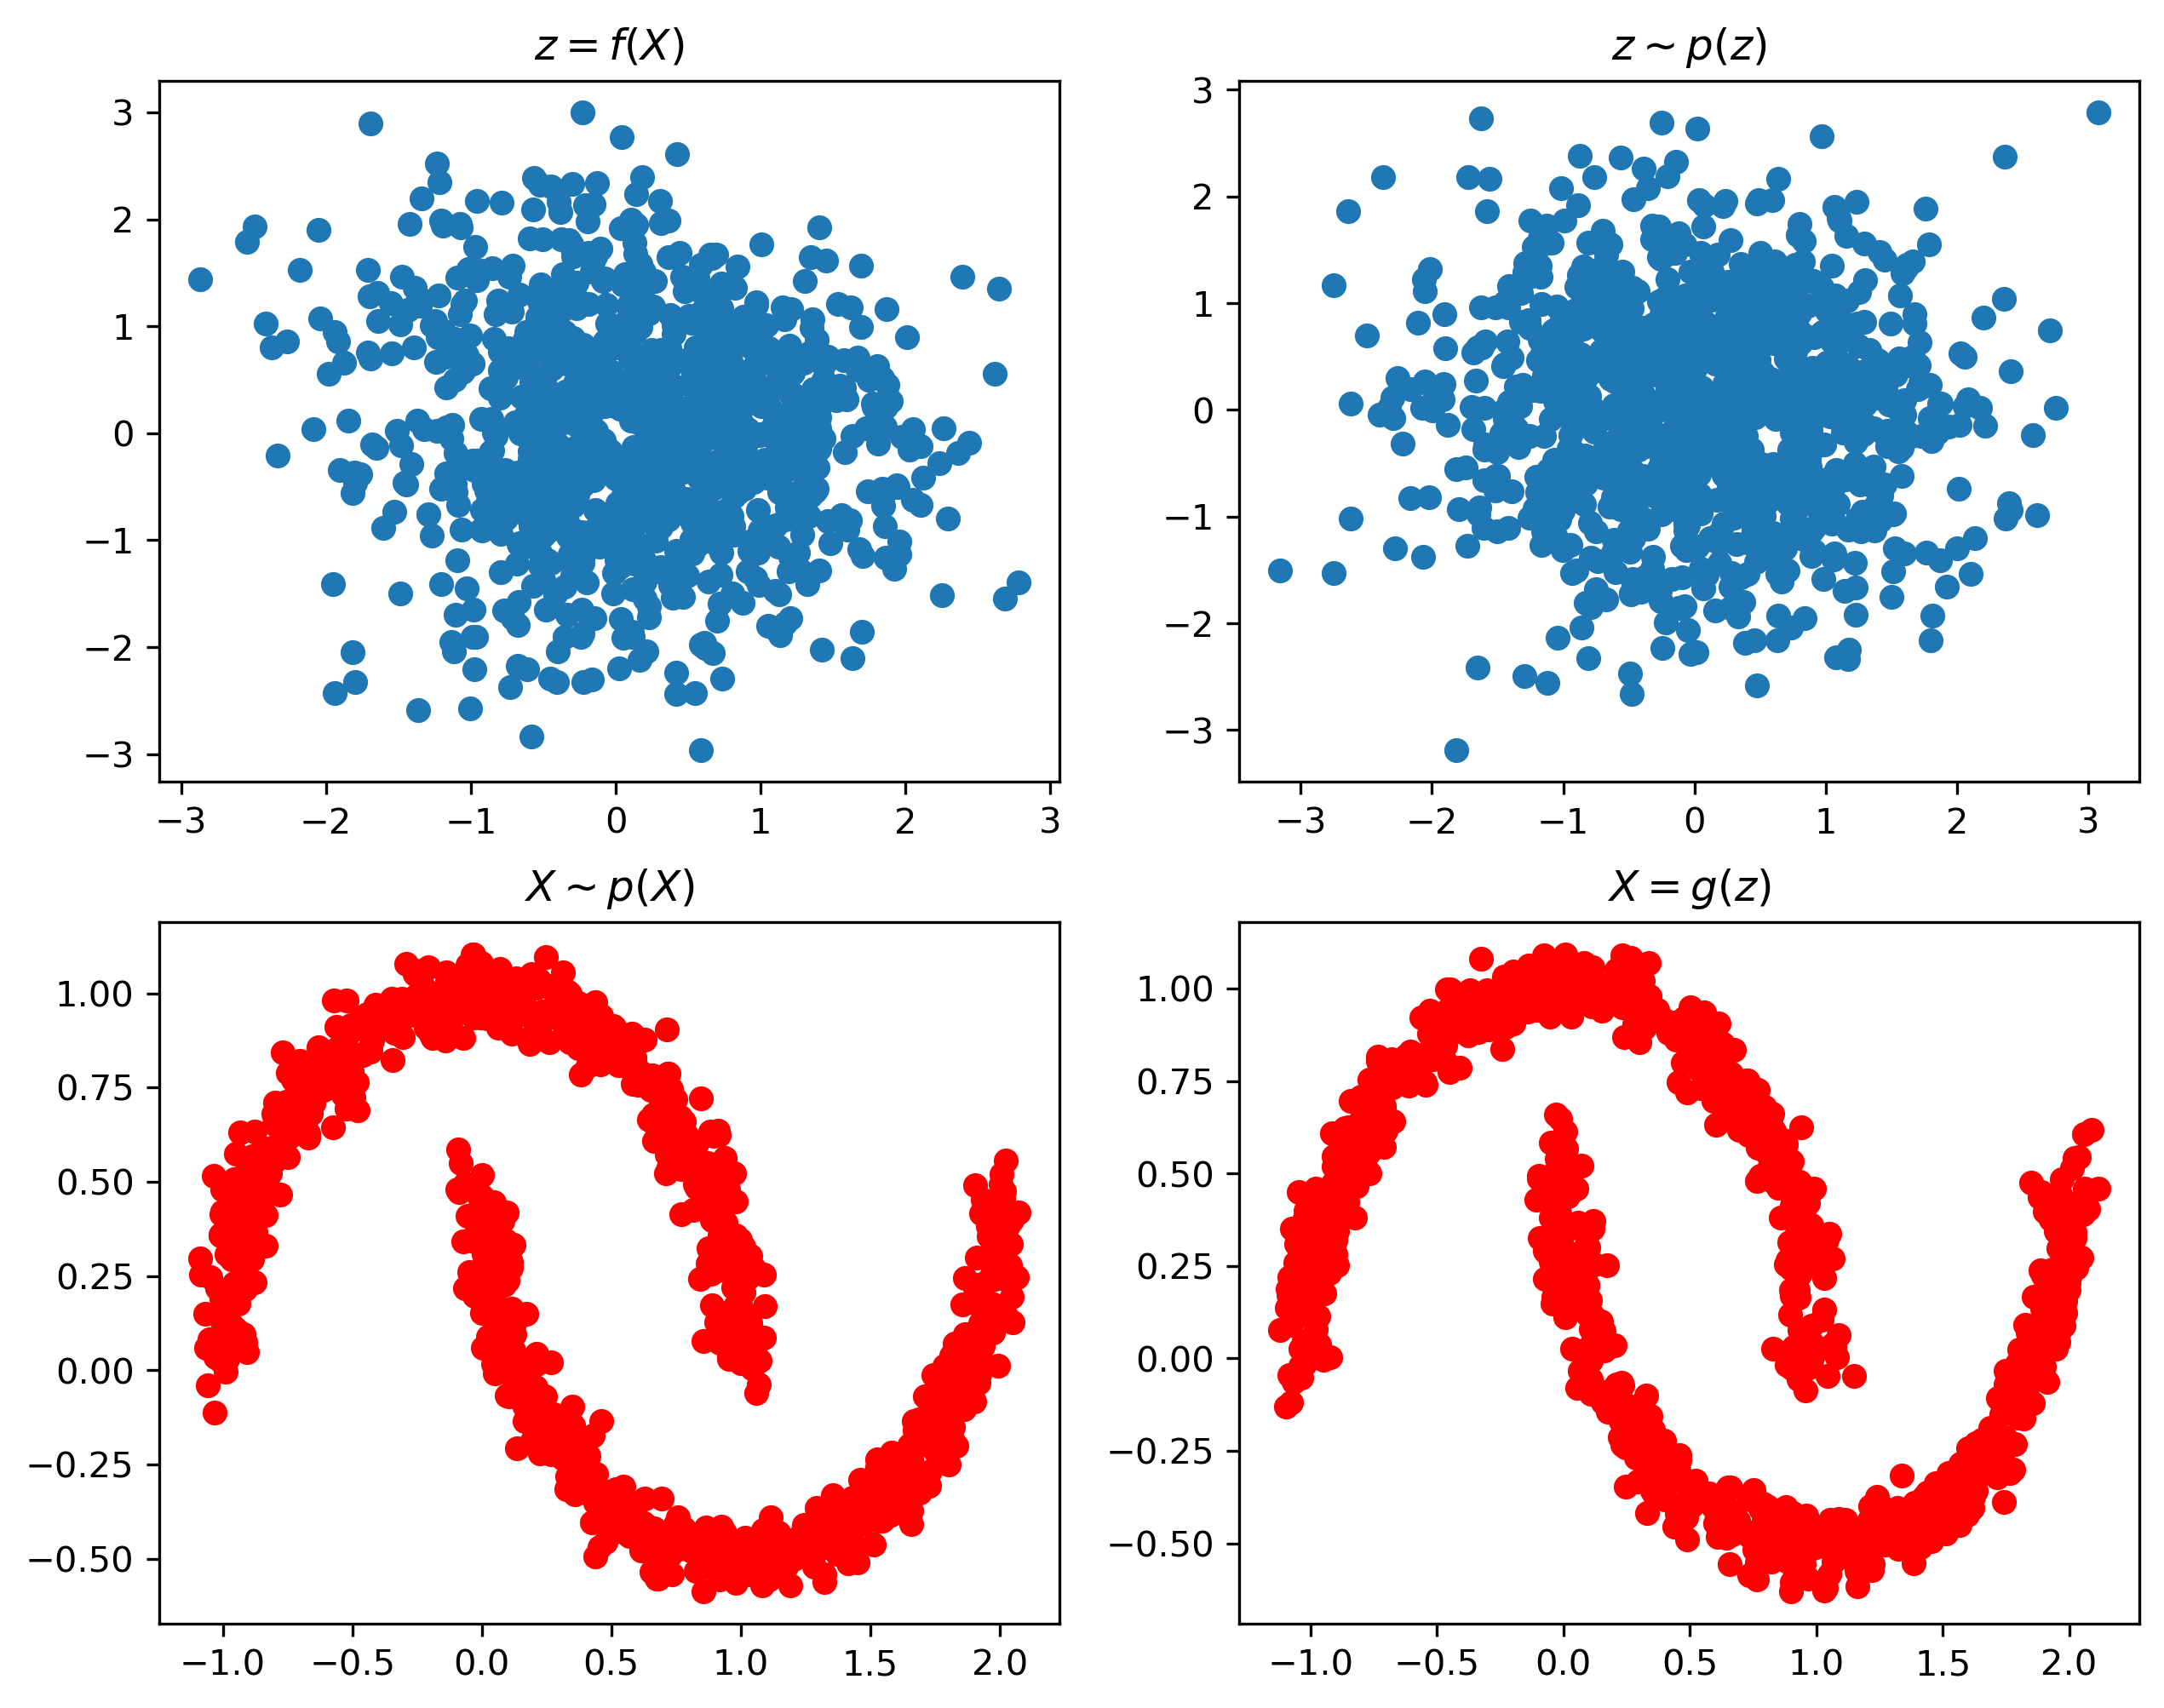

In [26]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()

#### 1)  lr = 1e-3, ####

#### 2) Linear(2, 128) ReLU Linear(128, 128) ReLU Linear(128, 2) nn.Tanh()) ####

#### 3) Linear(2, 256) LeakyReLU, Linear(256, 256), LeakyReLU(), Linear(256, 2))#### 

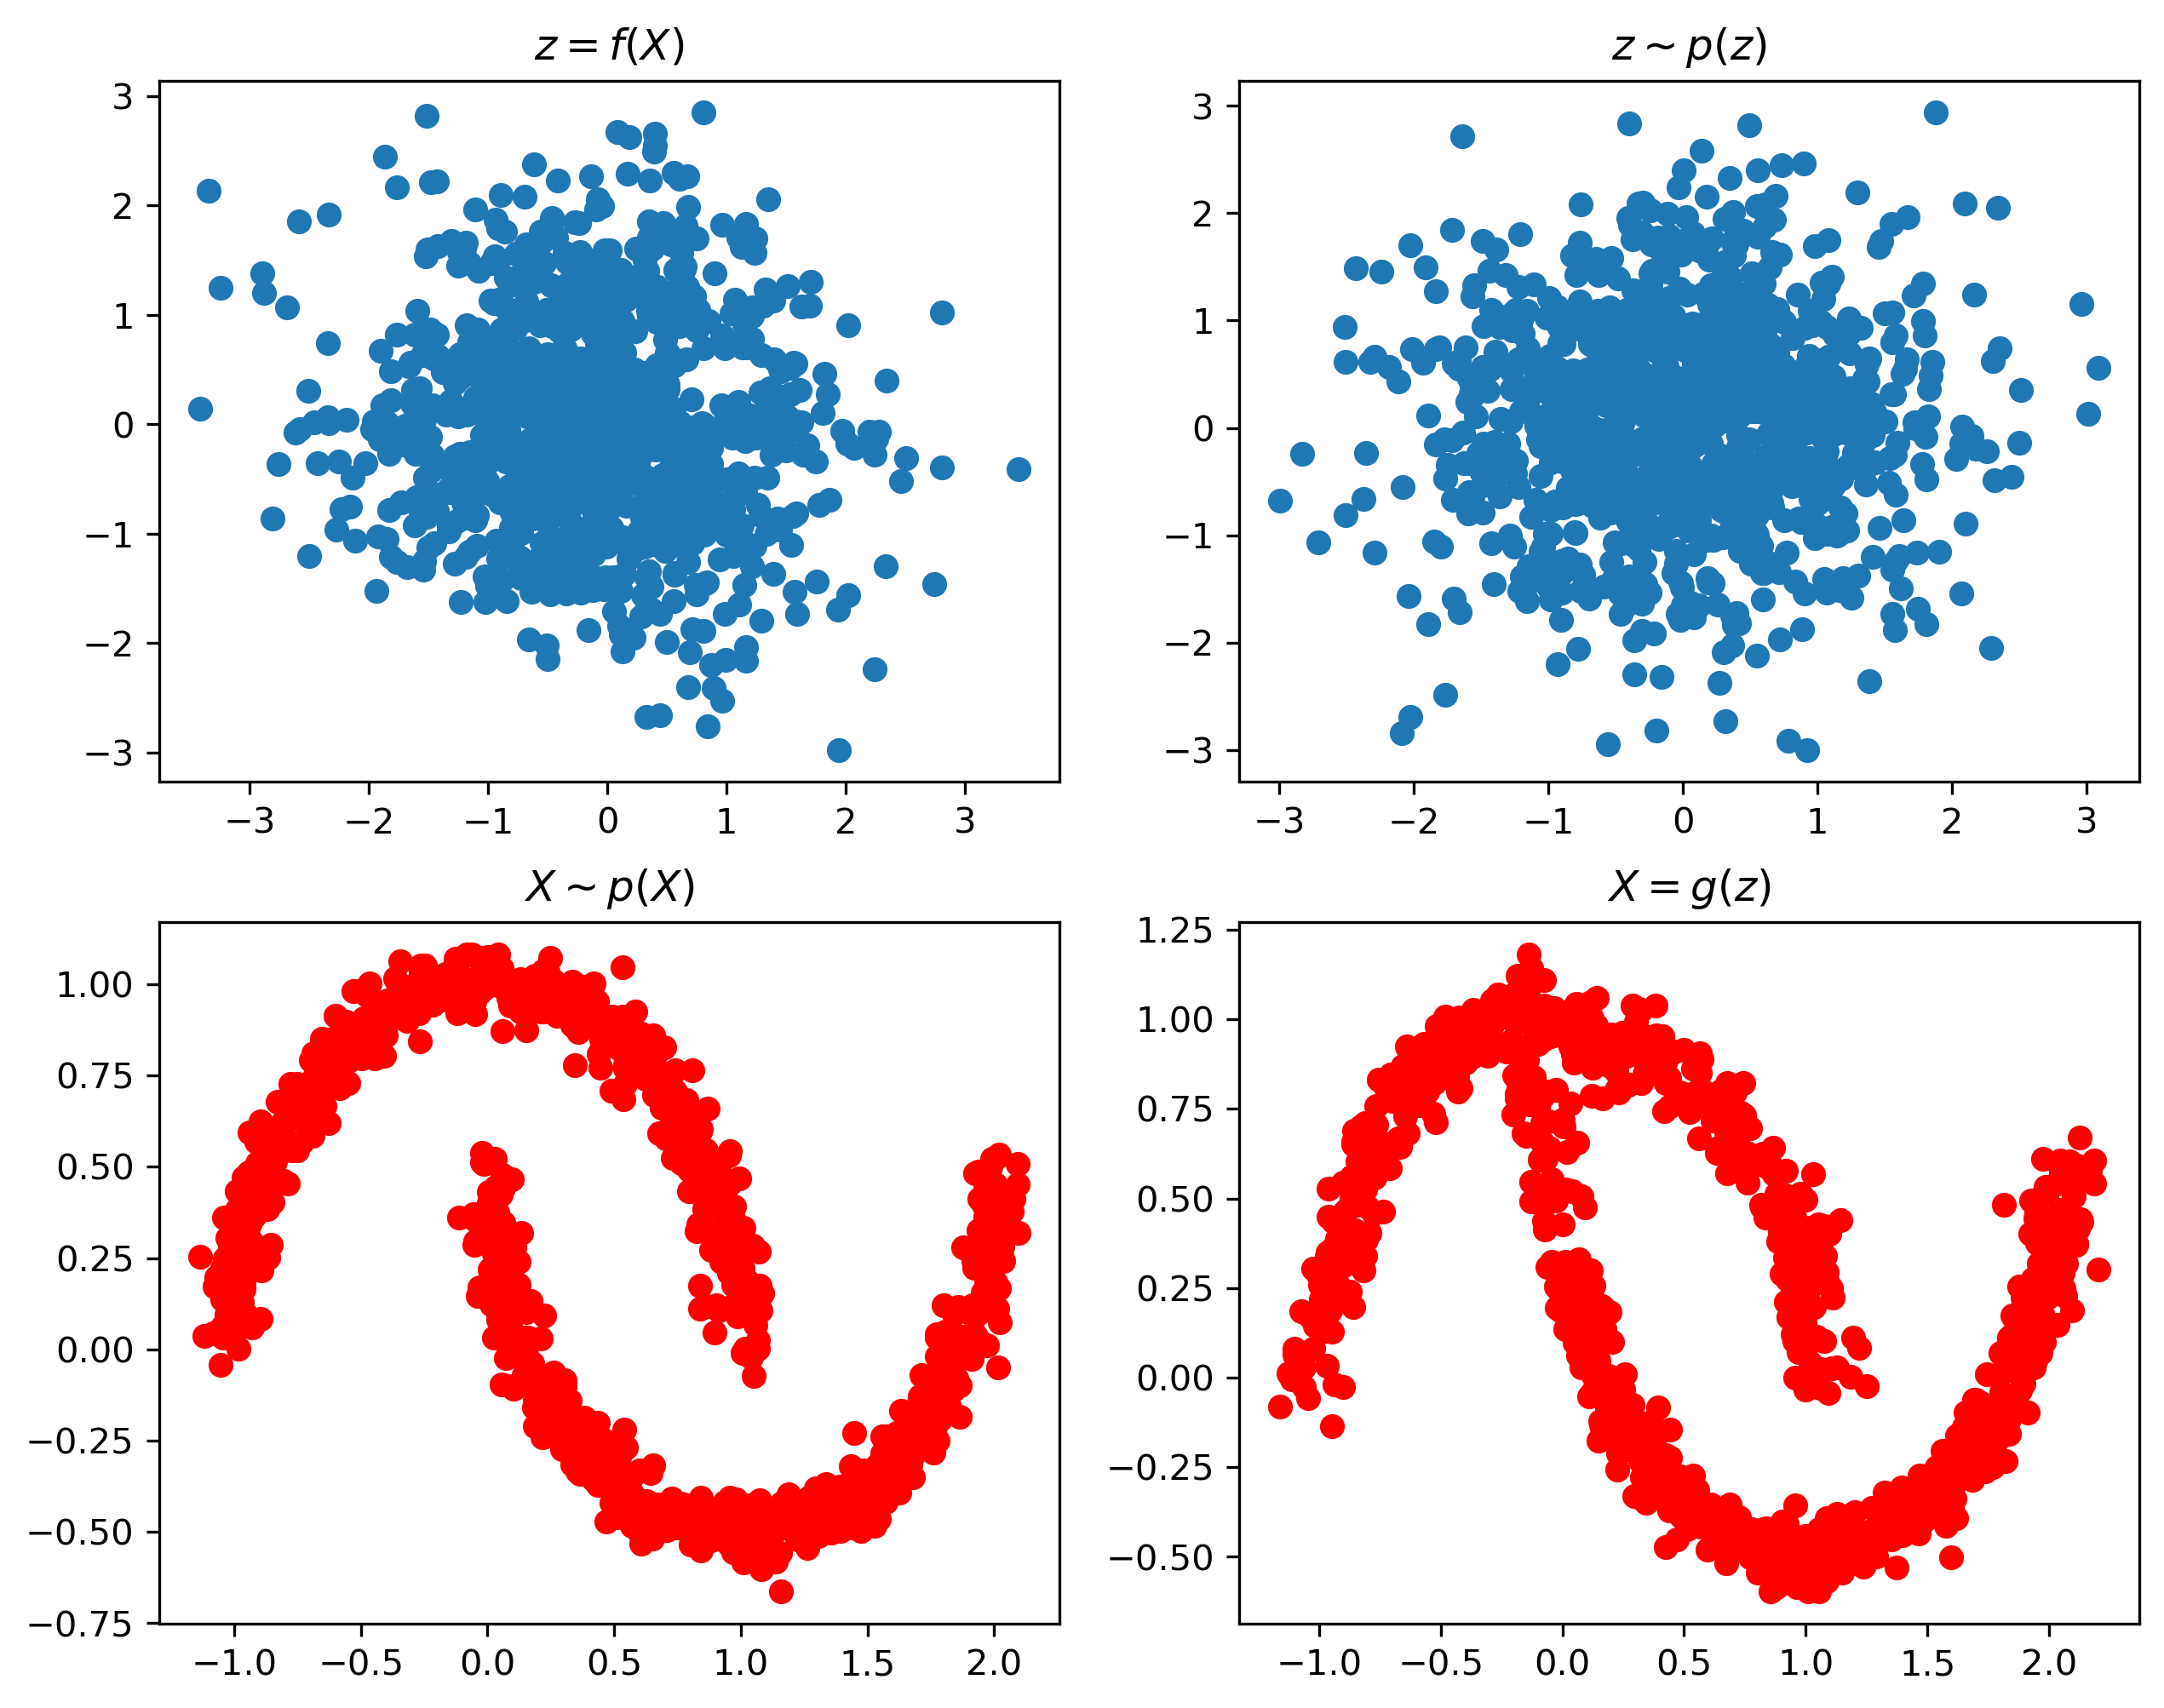

In [51]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()

#### 1)  lr = 1e-4, ####

#### 2) Linear(2, 64) ReLU Linear(64, 64) ReLU Linear(64, 2) nn.Tanh()) ####

#### 3) Linear(2, 64) LeakyReLU, Linear(64, 64), LeakyReLU(), Linear(64, 2))#### 

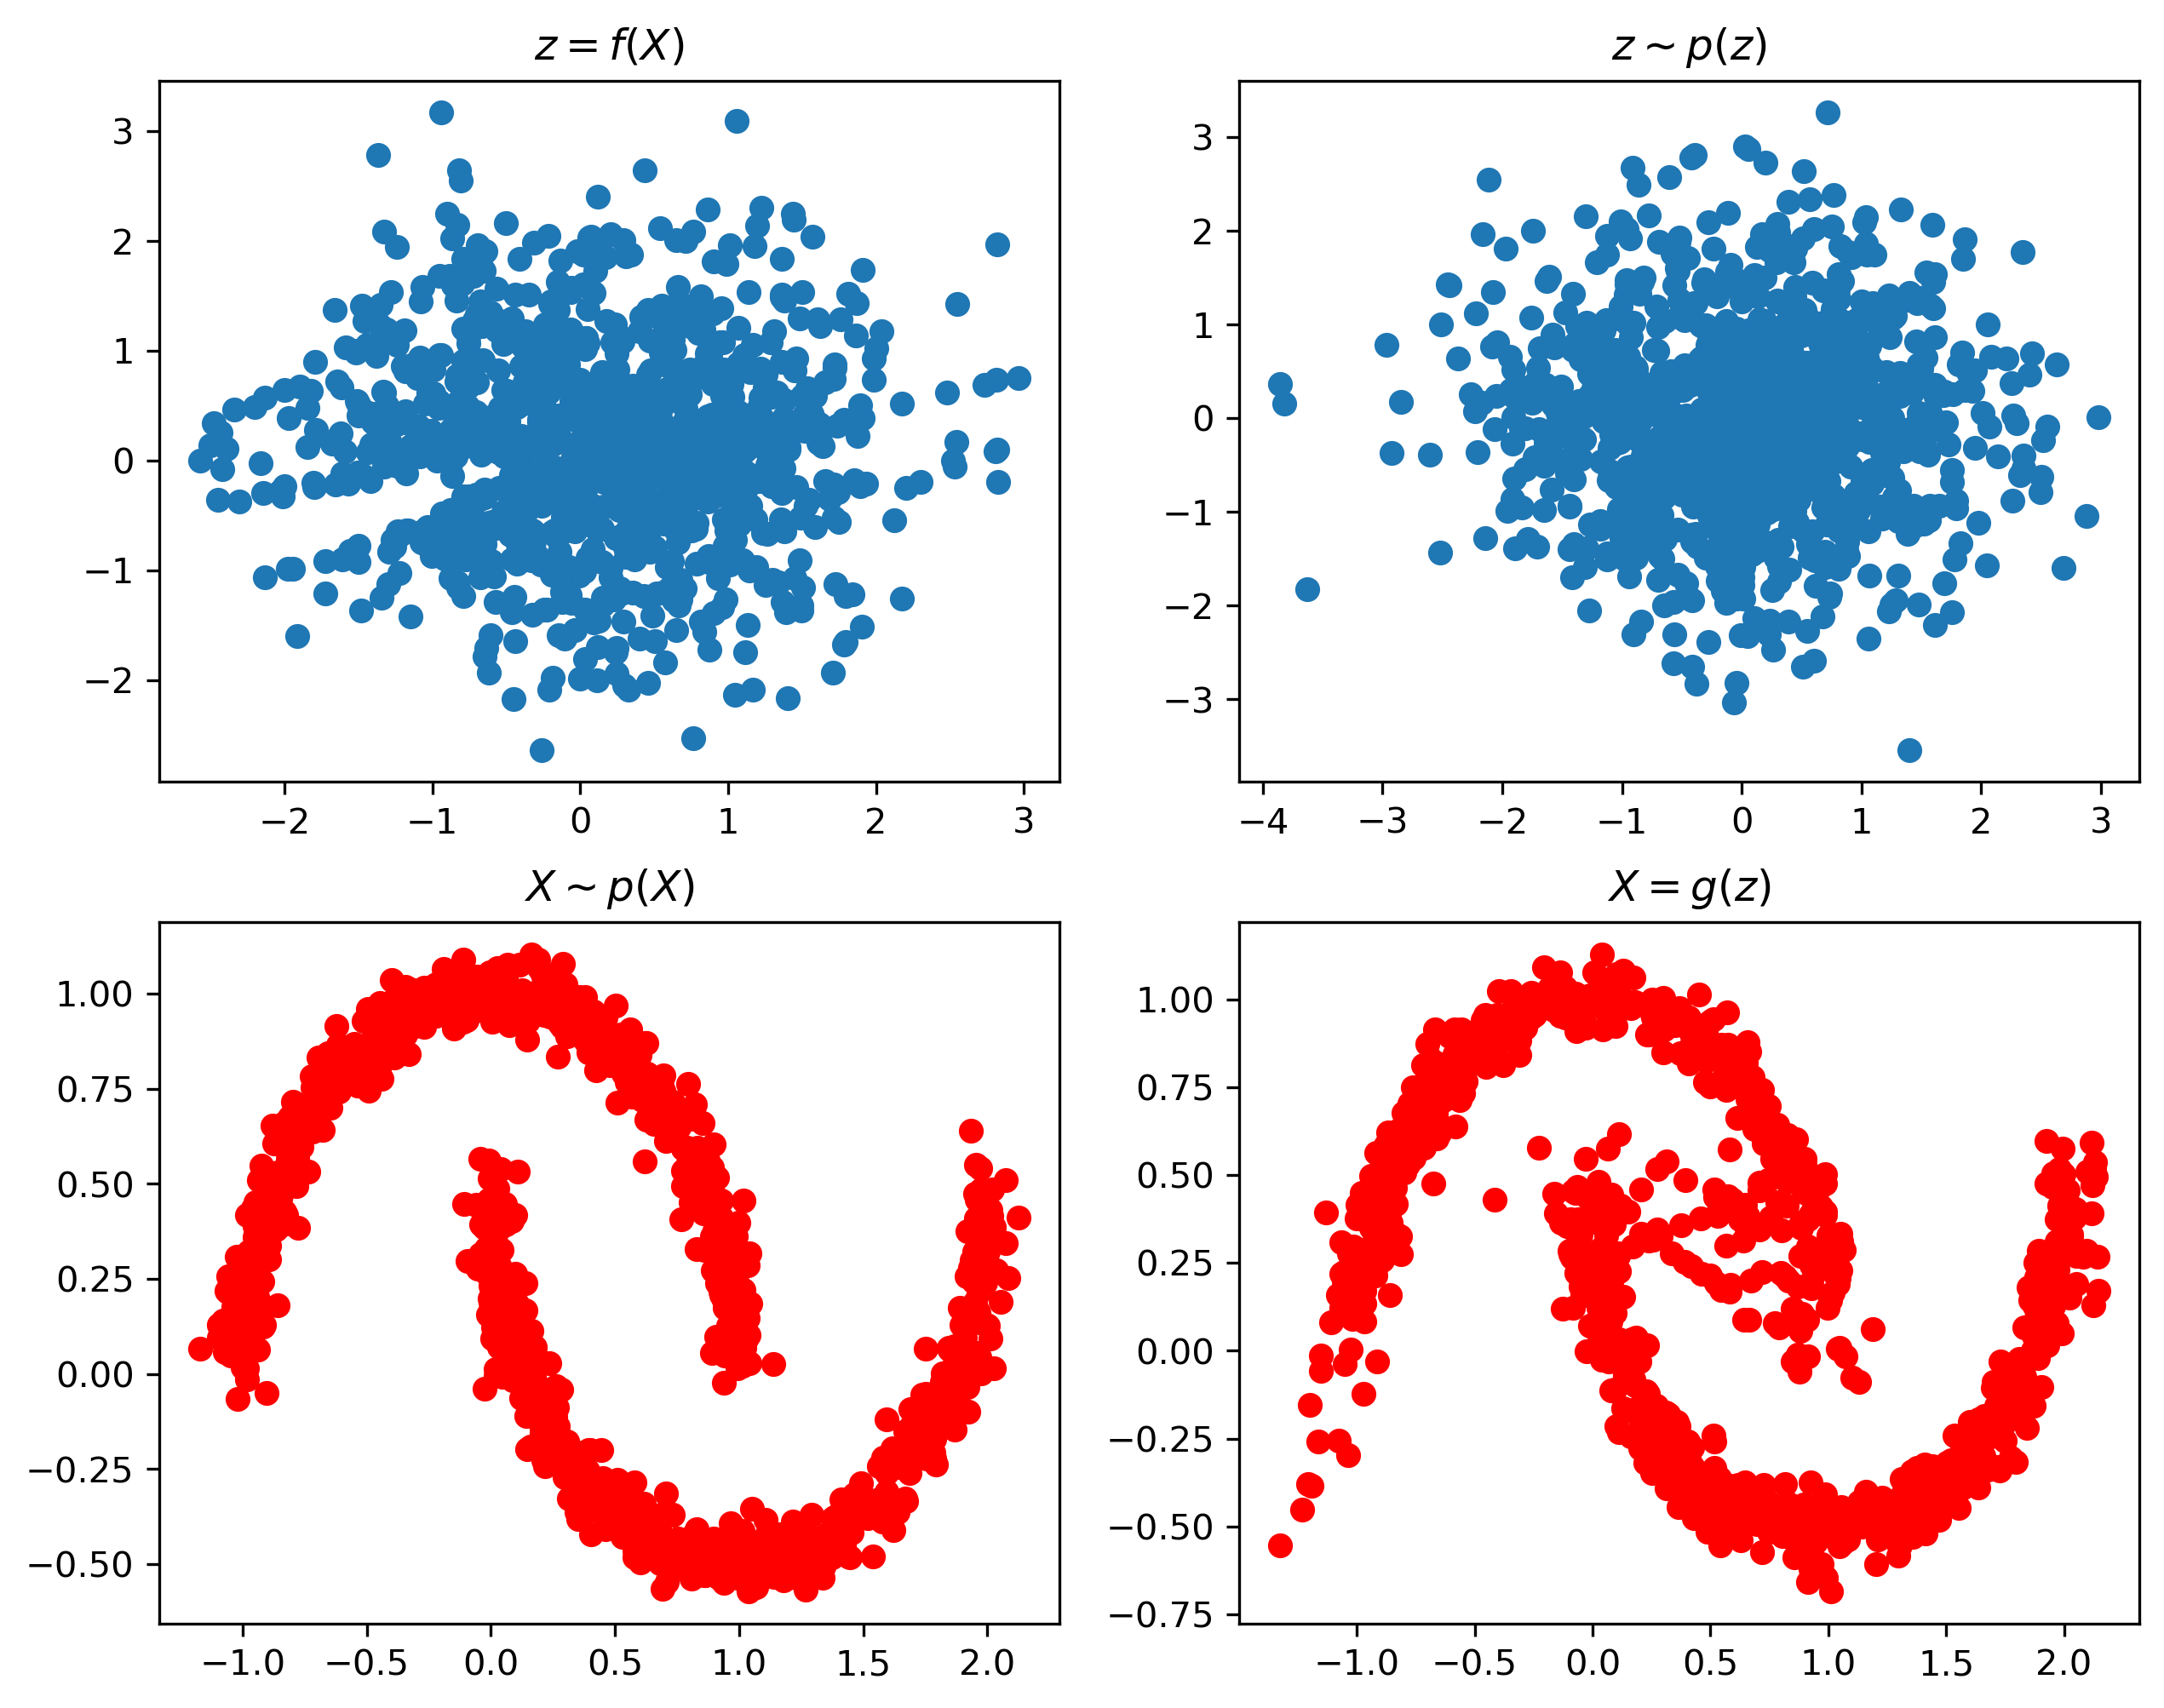

In [99]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()

#### 1)  lr = 1e-4, ####

#### 2) Linear(2, 256) ReLU Linear(256, 256) ReLU Linear(256, 2) nn.Tanh()) ####

#### 3) Linear(2, 256) LeakyReLU, Linear(256, 256), LeakyReLU(), Linear(256, 2))#### 

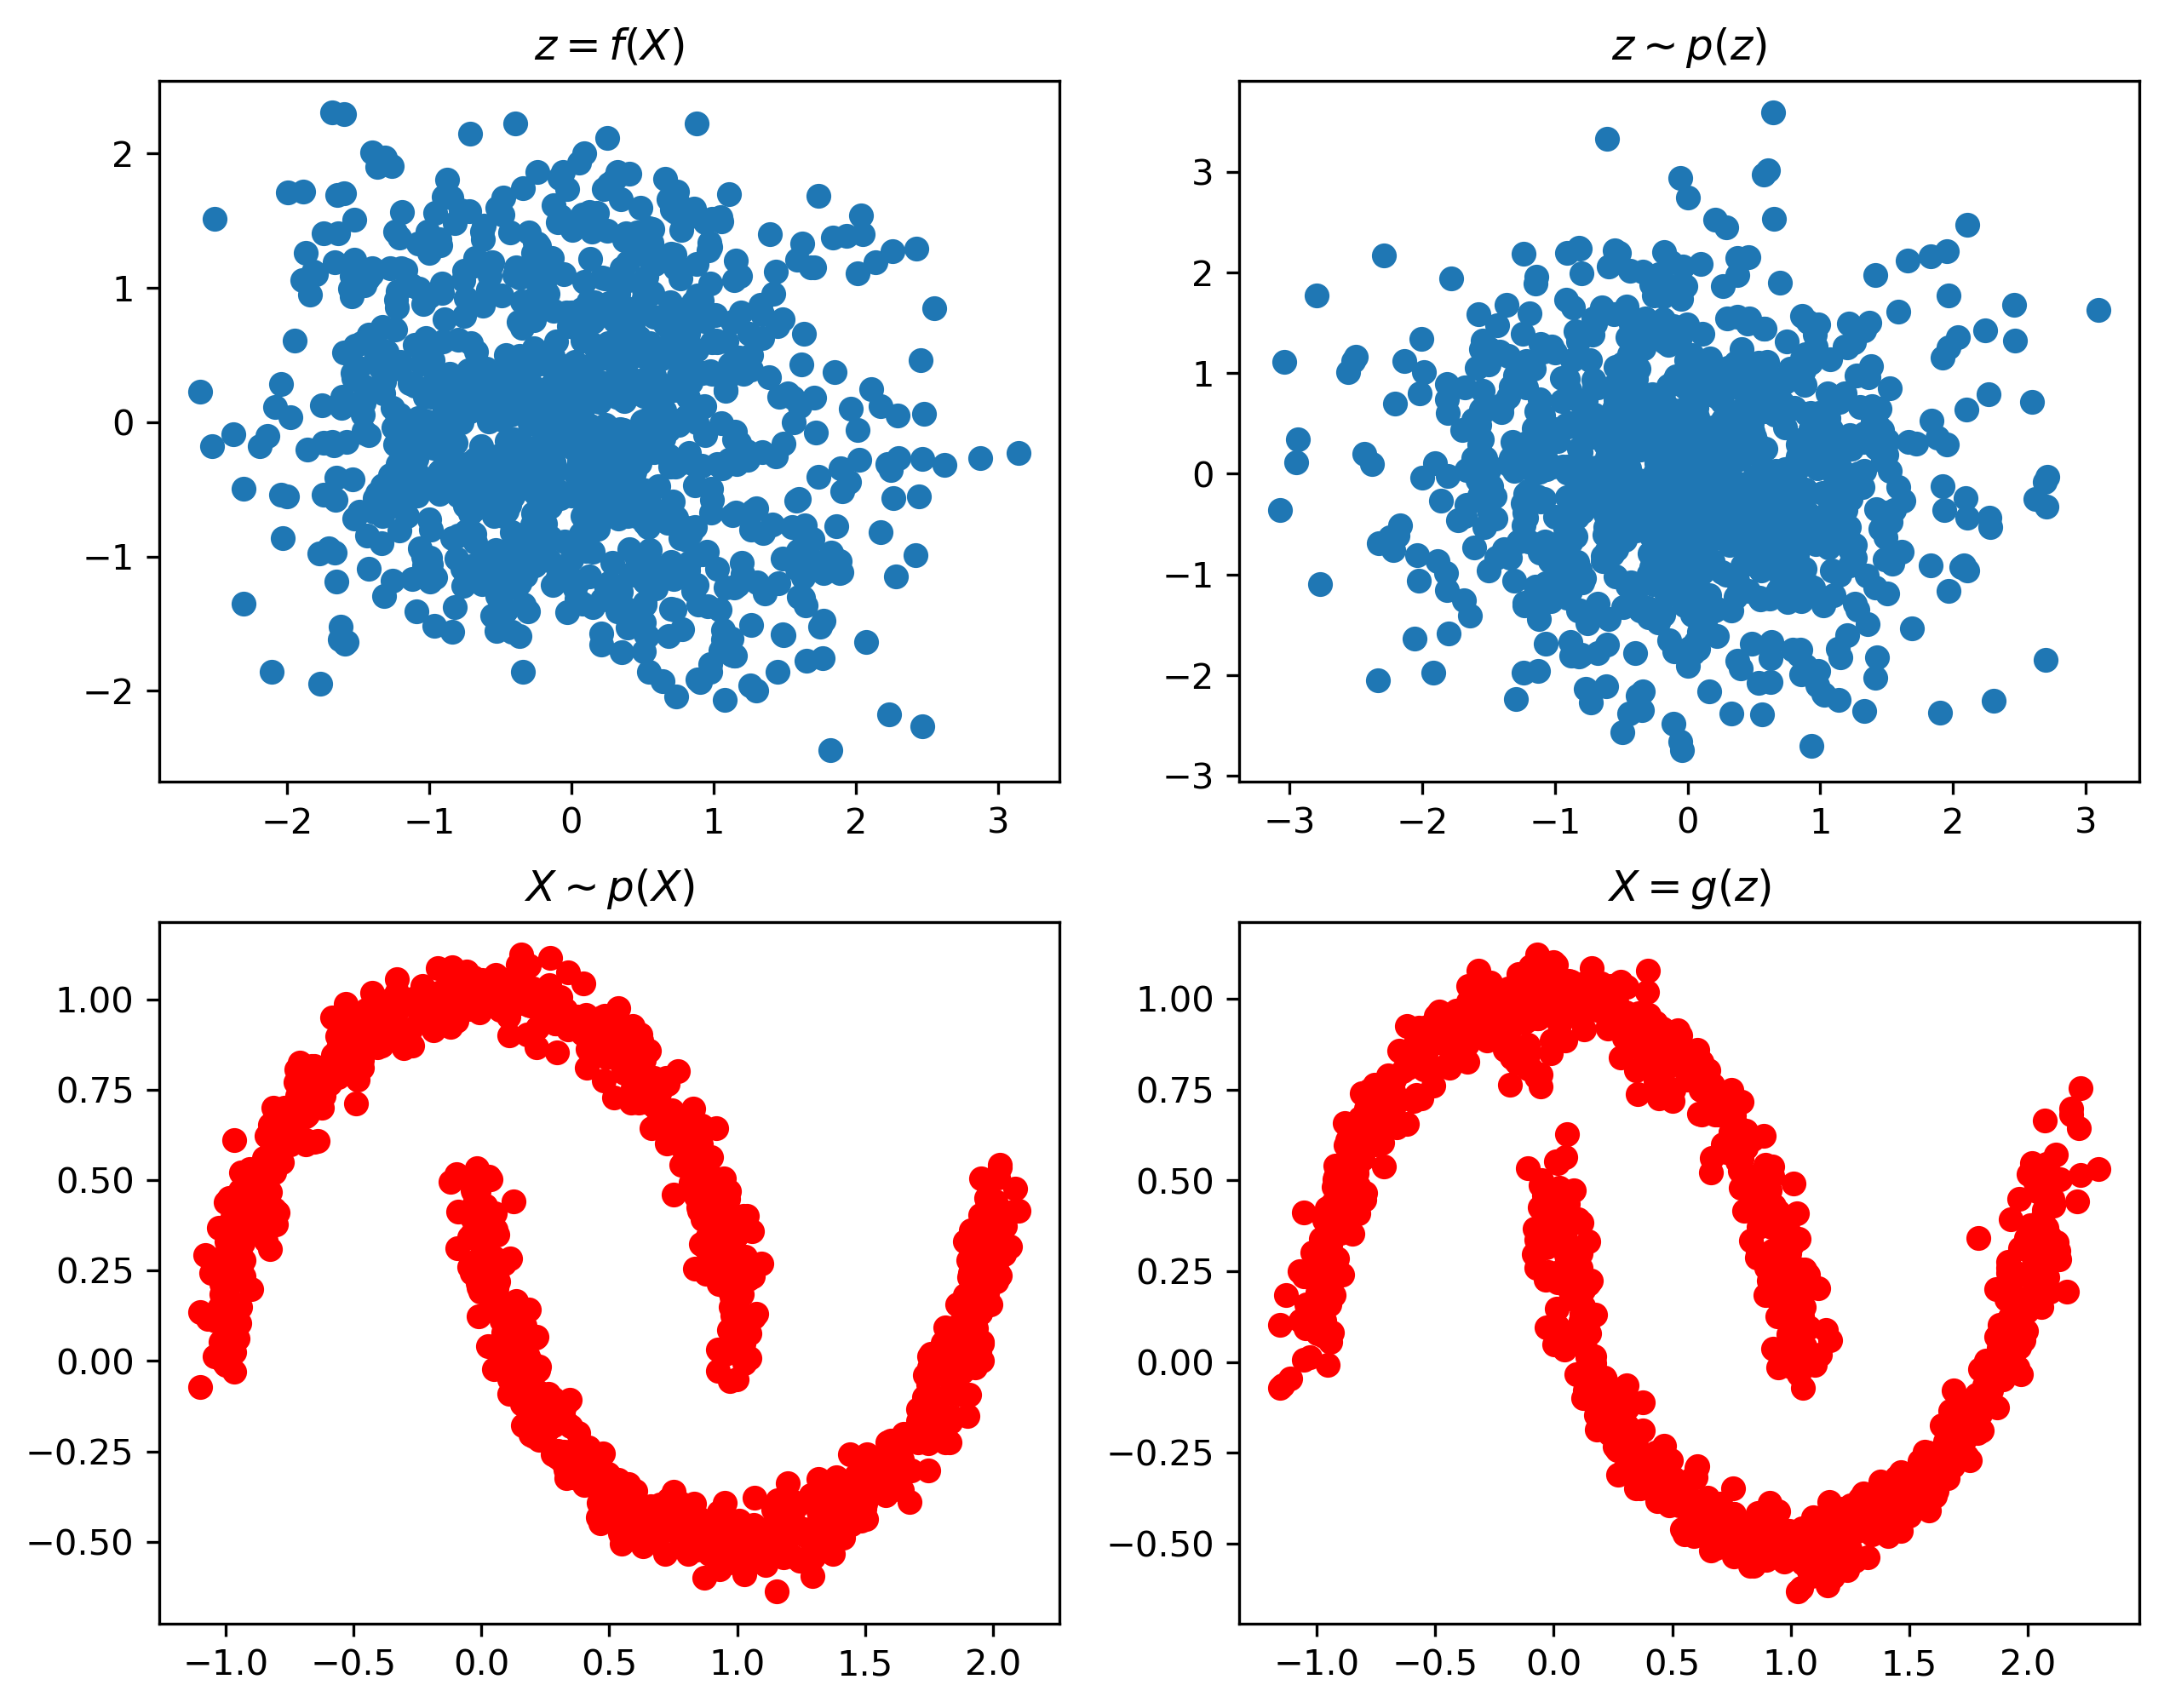

In [111]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()

#### 1)  lr = 1e-4, ####

#### 2) Linear(2, 256) ReLU Linear(256, 256) ReLU Linear(256, 256) ReLU Linear(256, 2) nn.Tanh()) ####

#### 3) Linear(2, 256) LeakyReLU, Linear(256, 256), LeakyReLU(), Linear(256, 256), LeakyReLU(), Linear(256, 2))#### 

#### 4 слоя####

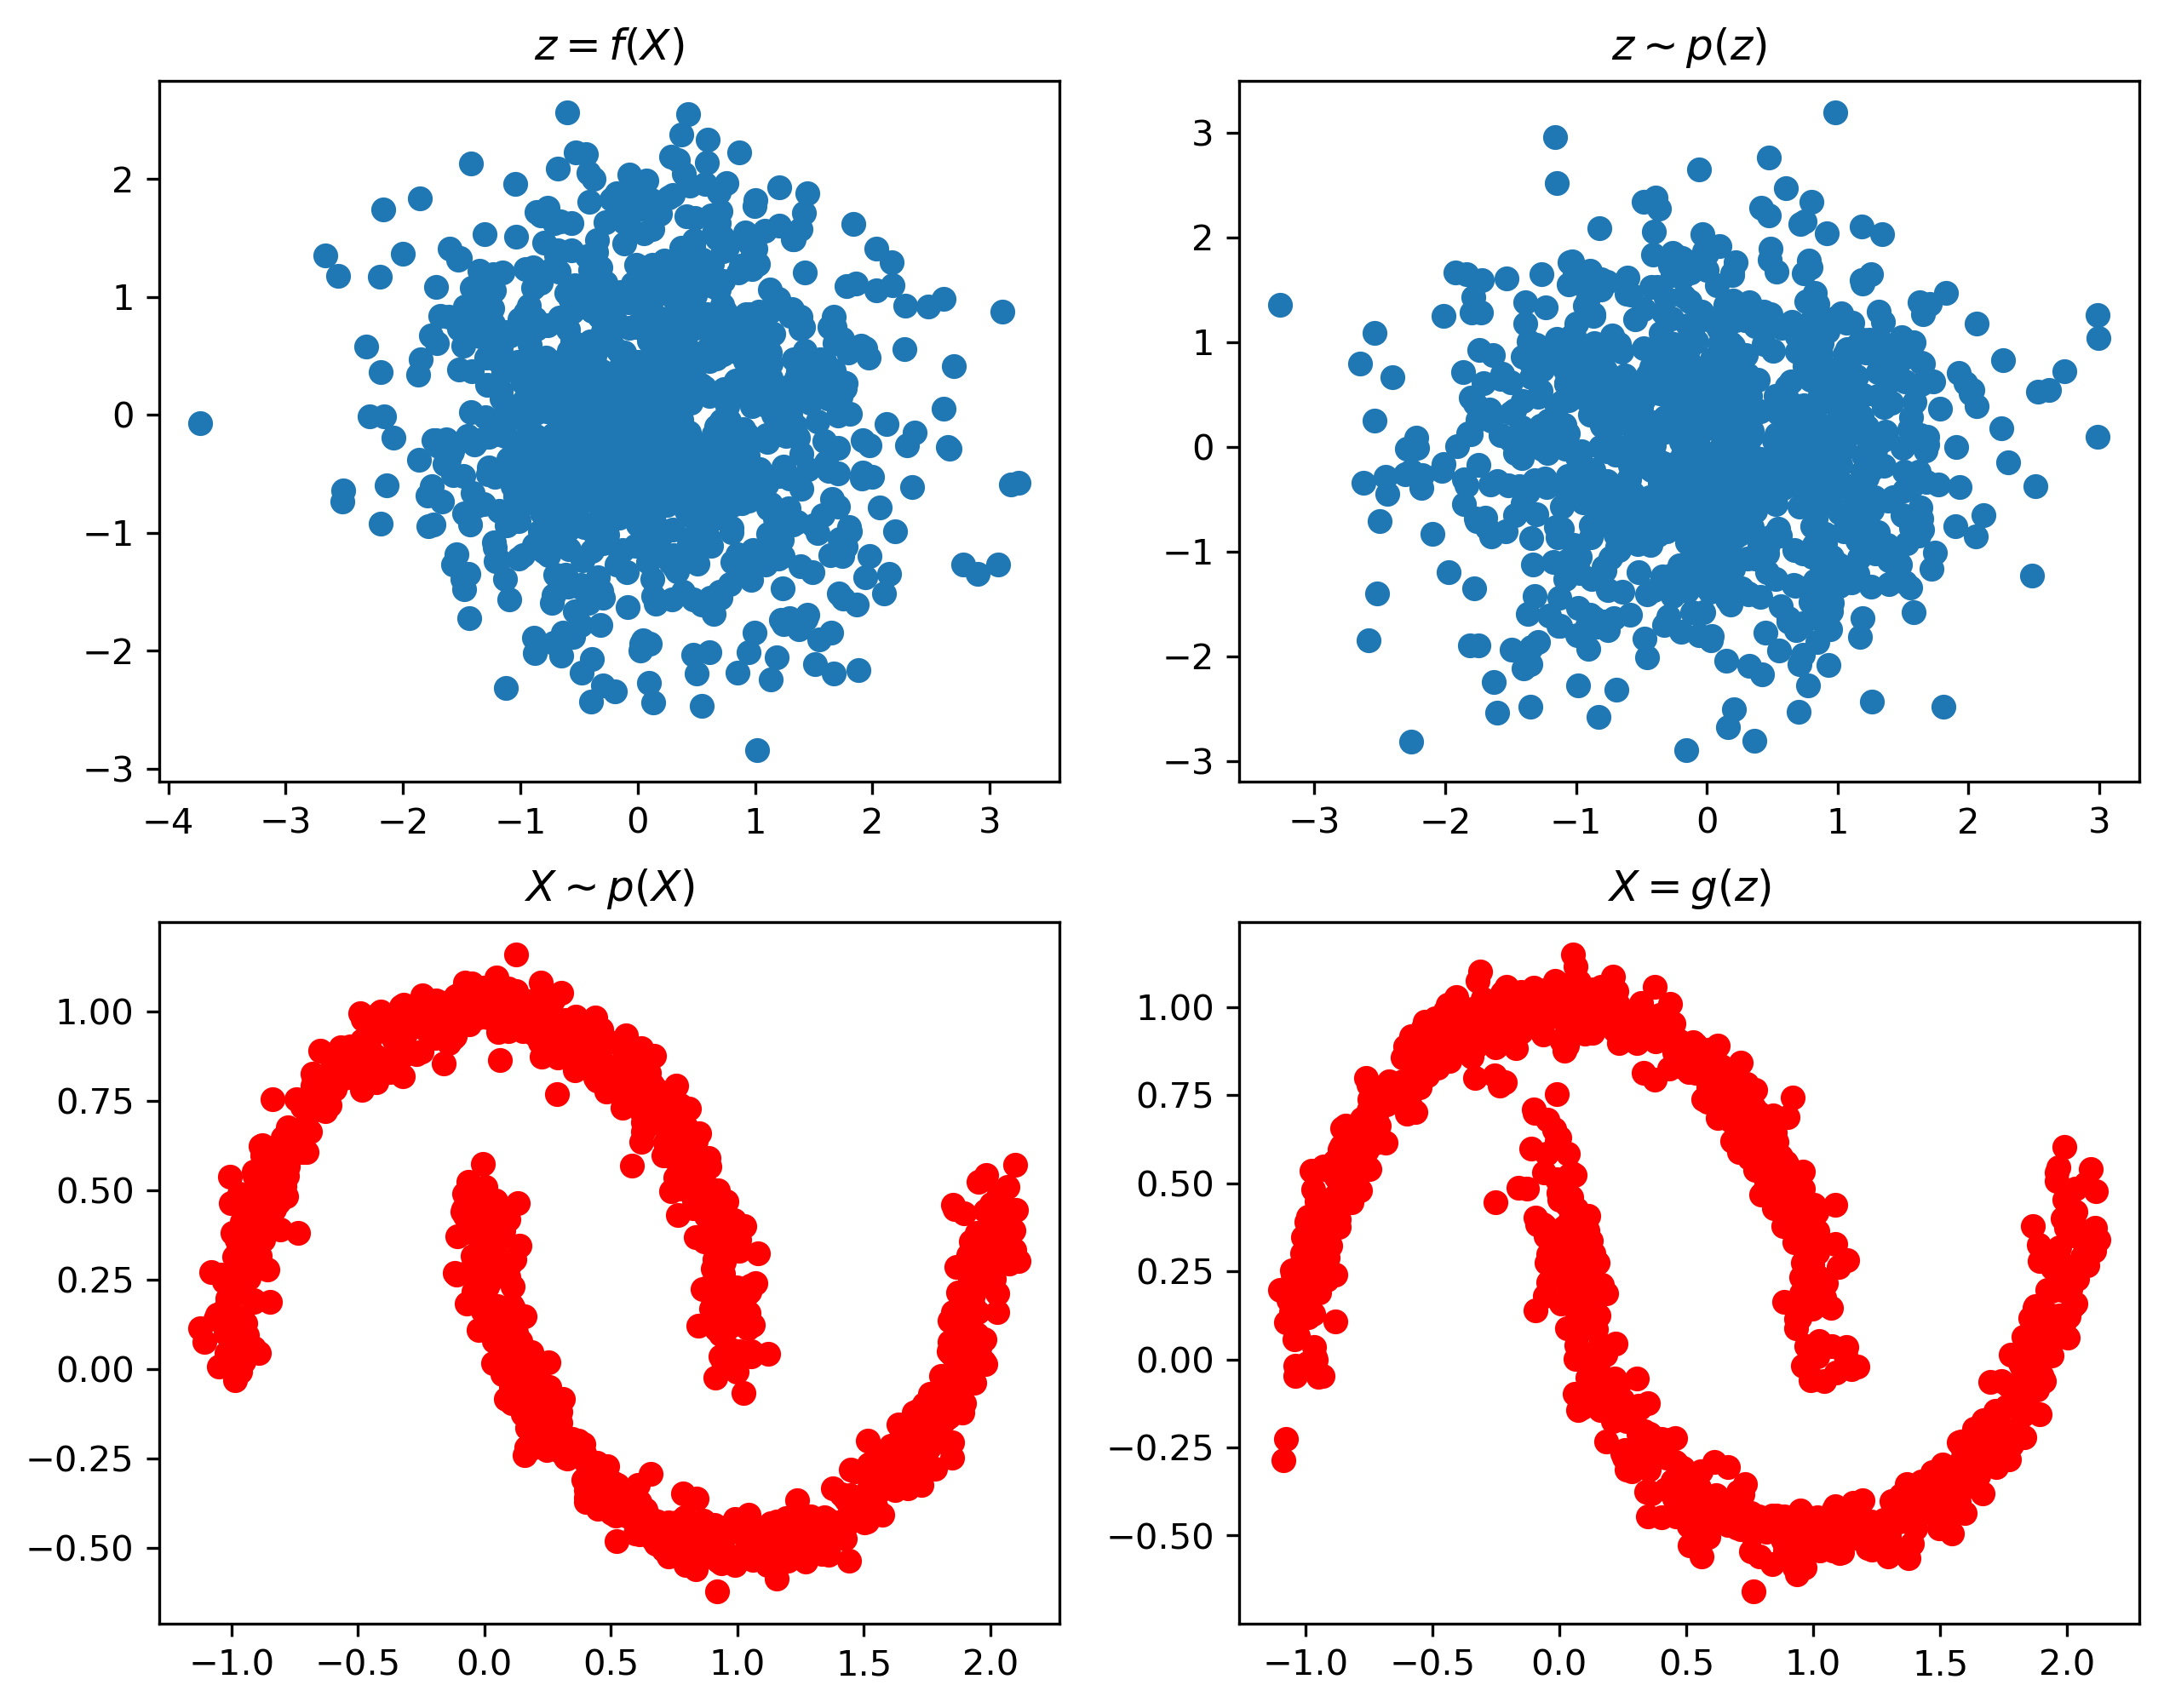

In [146]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()


#### 1)  lr = 1e-4, ####

#### 2) Linear(2, 256) ReLU Linear(256, 256) ReLU Linear(256, 256) ReLU Linear(256, 2) ReLU Linear(256, 256) nn.Tanh()) ####

#### 3) Linear(2, 256) LeakyReLU, Linear(256, 256), LeakyReLU(), Linear(256, 256), LeakyReLU(), Linear(256, 2) LeakyReLU(), Linear(256, 2)#### 

#### 5 слоев####

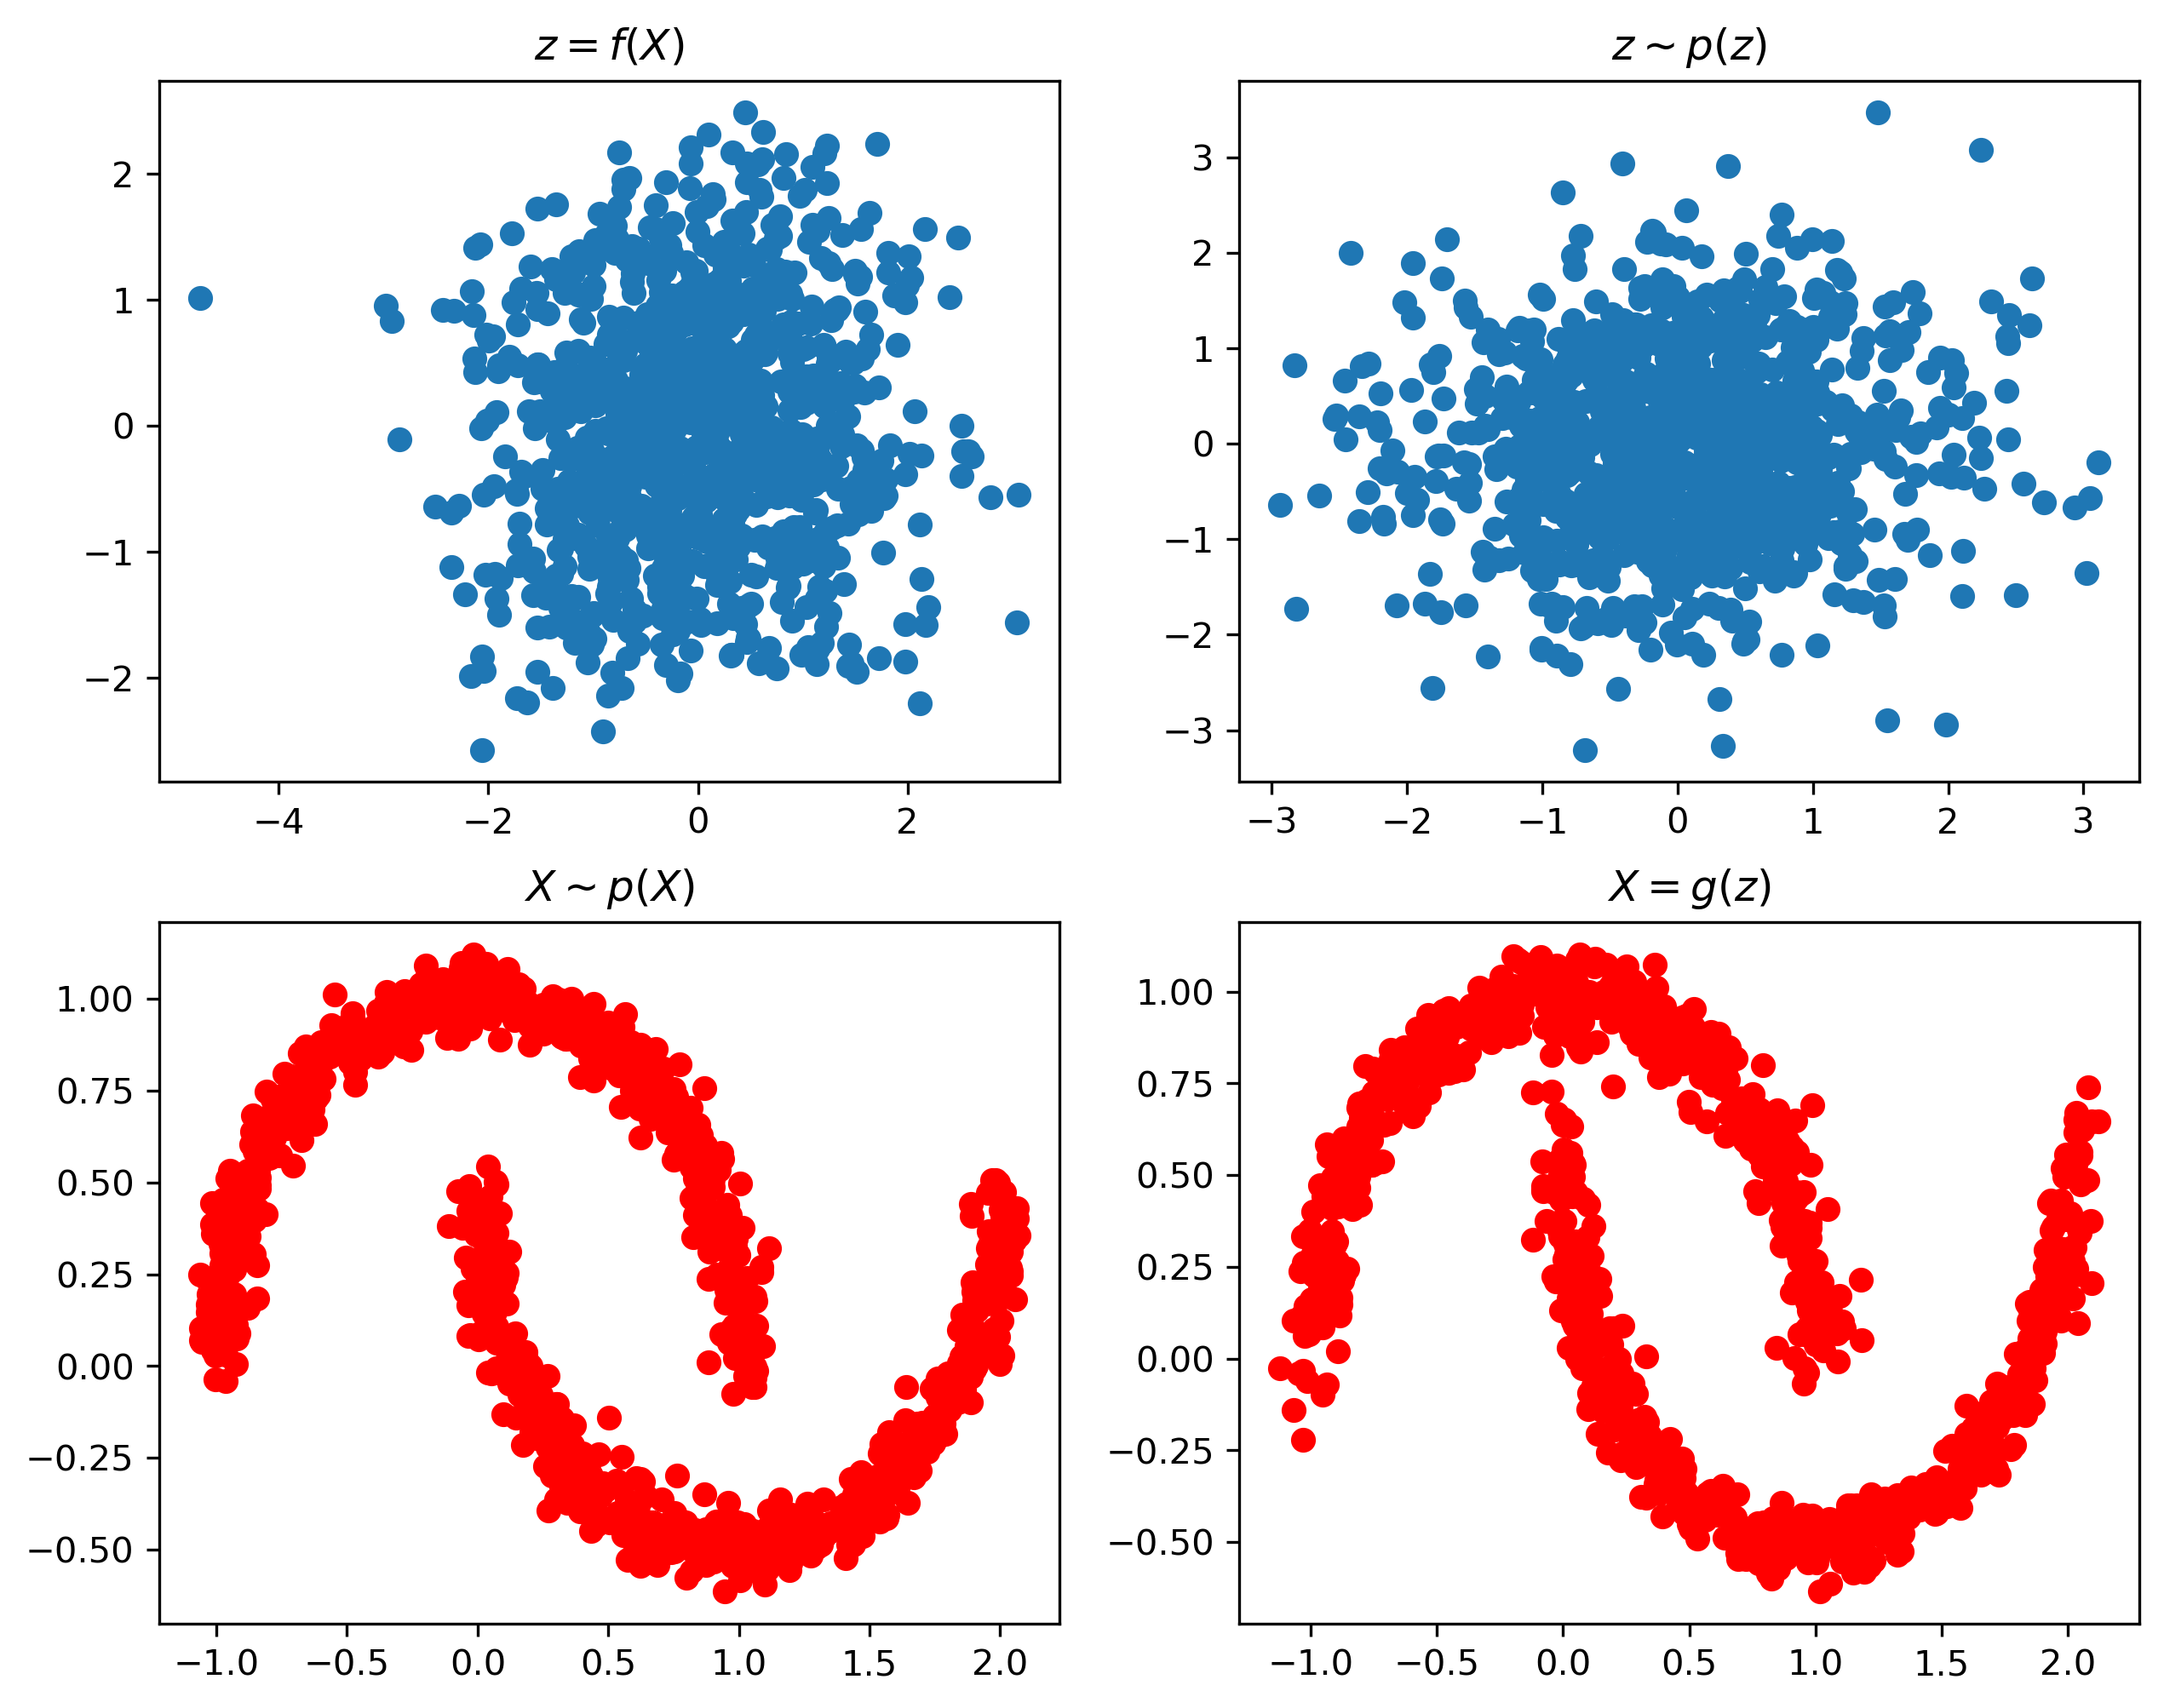

In [158]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')
plt.show()

## Provide answers for the folowing questions:

1. What architecture worked better in your experiments?


**Чем меньше размер слоев, тем хуже разделяются параметры. Однако хорошее разделение происходит уже при 256 и 128 размеров, и дальнейшее их увеличениелишь увеличивает время работы программы. (разделение на 1 картнке скорее случайность сэмплирования, на самом деле ту перегородку до конца убрать не получается)**


**На первом графике видна архитектура с тремя слоями, на предпоследнем с четырьмя, последнем с пятью. На самом деле есть ощущение, что на конечный лосс сложность архитектуры влияет не так существенно. (улучшить качество не удаается). Однако с более сложной архитектурой данных сходимость была быстрее. Ради демонстрации подбора параметров была предложена архитектура с тремя слоями, тк она обучалась немного быстрее.**

2. Did you find what is important for stable training (initializations, nonlinearities, ...)?


**lr влияет на скорость сходимости эксперимента при lr = 1e-4 результат сходится намного лучше чем lr = 1e-5**
**стоит отметить, что для любой архитектуре при неудачном выборе lr точного разделения не происходит. lr 1e-3 оказался достаточно большим. Также на малекьком количестве слоев даже правильный подбор гиперпараметров не дает хорошего результата (относительно большего количества)**


3. How convergence speed (in iterations) depends on the complexity of architecture?


**чем сложнее была архитектура, тем быстрее была сходимость (при одинаковом lr). однако усложнение архитектуры не помогало существенно улучшить результат работы алгоритмов. на трех линейных слоях уже получается адекватный результат**


# Optional Research Assignments:

This assignment is optional. It will give you up to 2 additional points for one of the assignments.   
#### 1. VAE: 
Use normalizing flow to get more expressive $q(z\,|\,x)$,  https://arxiv.org/abs/1505.05770. TL;dr; use decoder to predict $z_0 \sim q_0(z_0|x)$, then use NF to obtain $z_k = f_k \circ \dots \circ f_1(z)$ sample from a more flexible distribution. Compare it with a conventional normal distribution, what is working better? Compare it with conventional VAE  that uses the same number of parameters as VAE with NF.

#### 2. More complex data: 
Train NFs for a more complex dataset e.g. MNIST (downscale is possible), make samples look reasonable e.g., solid fraction of samples can be recognized as a valid digits. Worth to use Conv2d layers for s and t.
